In [1]:
import data_load
import pandas as pd
import glob
import matplotlib.pyplot as plt 
import numpy as np
from datetime import datetime, timedelta


In [2]:
cdc_frames = data_load.get_cdc_dataframe ()

In [3]:
jhu_frames = data_load.get_jhu_dataframe ()

<AxesSubplot:xlabel='Date'>

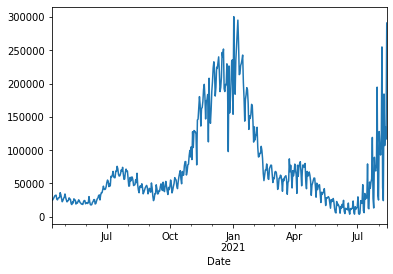

In [4]:
jhu_frames["NewCases"].plot()

In [5]:
def add_days(date, days):
    date_1 = datetime.strptime(date, "%Y-%m-%d")
    end_date = date_1 + timedelta(days=days)
    return end_date.strftime('%Y-%m-%d')

In [6]:
jhu_weekly={}
for target_date in cdc_frames.target_end_date.unique():
    if not target_date in jhu_frames.index:
        continue
    weeklySum = jhu_frames.loc[target_date].NewCases
    for i in range(6):
        pastDate = add_days(target_date, -(i+1))
        weeklySum += jhu_frames.loc[pastDate].NewCases
    jhu_weekly[target_date] = weeklySum

In [7]:
jhu_weekly_df = pd.DataFrame.from_dict(jhu_weekly,orient='index', columns=['WeeklyCases']).sort_index(ascending=True)
jhu_weekly_df = jhu_weekly_df.reset_index()
jhu_weekly_df = jhu_weekly_df.rename(columns={"index": "target_end_date"})
jhu_weekly_df.target_end_date=pd.to_datetime(jhu_weekly_df.target_end_date)
jhu_weekly_df = jhu_weekly_df.set_index("target_end_date", drop=True).sort_index(ascending=True)

<AxesSubplot:xlabel='target_end_date'>

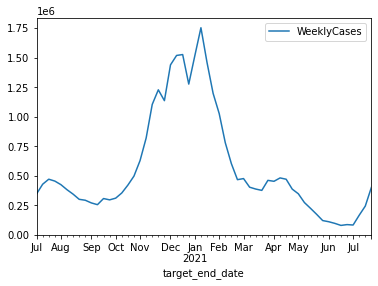

In [8]:
jhu_weekly_df.plot()

In [9]:
cdc_frames.Model.unique()

array(['BPagano-RtDriven', 'CEID-Walk', 'COVIDhub-baseline',
       'COVIDhub-ensemble', 'CU-nochange', 'CU-scenario_high',
       'CU-scenario_low', 'CU-scenario_mid', 'CU-select',
       'Columbia_UNC-SurvCon', 'Covid19Sim-Simulator',
       'CovidAnalytics-DELPHI', 'FDANIHASU-Sweight',
       'FRBSF_Wilson-Econometric', 'Geneva-DetGrowth', 'IBF-TimeSeries',
       'IEM_MED-CovidProject', 'IUPUI-HkPrMobiDyR', 'IowaStateLW-STEM',
       'JHUAPL-Bucky', 'JHU_CSSE-DECOM', 'JHU_IDD-CovidSP',
       'KITmetricslab-select_ensemble', 'Karlen-pypm', 'LANL-GrowthRate',
       'LNQ-ens1', 'MIT_ISOLAT-Mixtures', 'MOBS-GLEAM_COVID',
       'Microsoft-DeepSTIA', 'OliverWyman-Navigator',
       'RobertWalraven-ESG', 'TTU-squider', 'UCF-AEM',
       'UChicagoCHATTOPADHYAY-UnIT', 'UMich-RidgeTfReg', 'USC-SI_kJalpha',
       'UVA-Ensemble', 'UpstateSU-GRU', 'COVIDhub-trained_ensemble',
       'MIT-Cassandra', 'MUNI-ARIMA', 'UCLA-SuEIR', 'USACE-ERDC_SEIR',
       'DDS-NBDS', 'IQVIA_ACOE-STAN', 'JCB-PR

In [10]:
start = "2020-03-01"
end = "2020-08-31"
stats={}
for model in cdc_frames.Model.unique():
    model_frame = cdc_frames[(cdc_frames["Model"]==model) & (cdc_frames["target"] == "4 wk ahead inc case")][["target_end_date", "point"]]
    model_frame = model_frame.set_index("target_end_date", drop=True)
    model_frame = model_frame.sort_index()
    model_target_df = model_frame[(model_frame.index > start) & (model_frame.index < end)]
    target_dates = model_target_df.index.unique()
    jnu_target_df = jhu_weekly_df.loc[list(target_dates)]
    jnu_target_df.diff = 100*abs(model_target_df.point - jnu_target_df.WeeklyCases)/jnu_target_df.WeeklyCases
    stats[model]={}
    stats[model]["mae"]= round(jnu_target_df.diff.mean(),2)
    stats[model]["pred_count"]= len(jnu_target_df)
    
stat_df =  pd.DataFrame.from_dict(stats,orient='index')
stat_df = stat_df[stat_df.pred_count>0]
stat_df = stat_df[stat_df.pred_count>= stat_df.pred_count.value_counts().idxmax()]
stat_df  = stat_df.sort_values("mae", ascending=True)

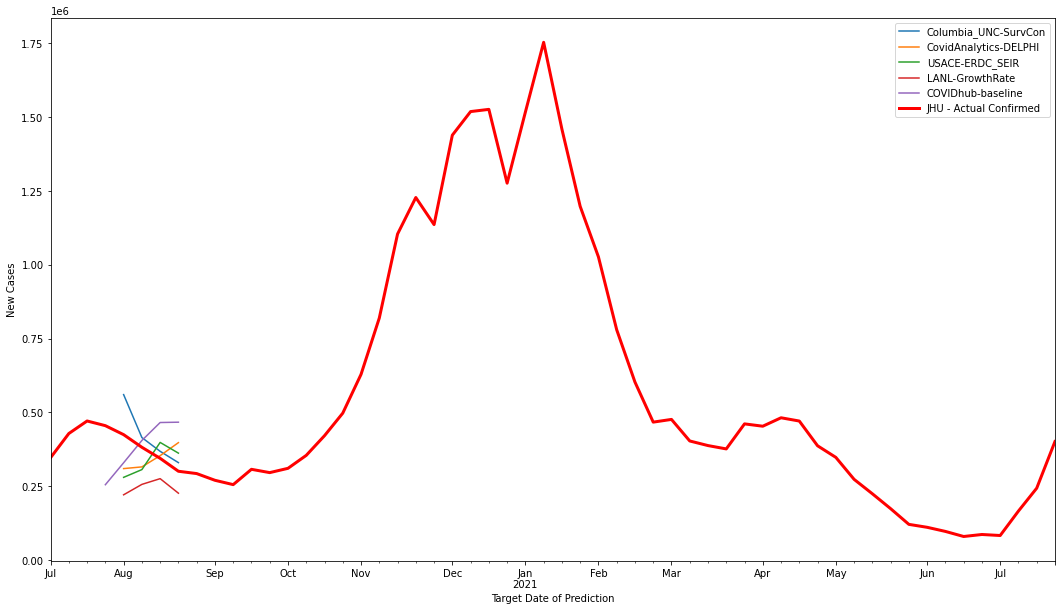

In [11]:
fig, ax = plt.subplots()
for model in stat_df.index[:5]:
    if model == "DDS-NBDS":
        continue
    model_frame = cdc_frames[(cdc_frames["Model"]==model) & (cdc_frames["target"] == "4 wk ahead inc case")][["target_end_date", "point"]]
    model_frame.target_end_date=pd.to_datetime(model_frame.target_end_date)
    model_frame = model_frame.set_index("target_end_date", drop=True)
    model_frame = model_frame[(model_frame.index > start) & (model_frame.index < end)]
    model_frame.sort_index()["point"].plot(figsize=(18,10),ax=ax,  label=model)
    #model_frame.sort_index()["point"].plot(figsize=(18,10),ax=ax, linewidth=1,  label='_nolegend_', color='b')
jhu_weekly_df["WeeklyCases"].plot( linewidth=3,ax=ax,  label="JHU - Actual Confirmed", color='r')
ax.legend()
ax.set(ylabel="New Cases", xlabel = "Target Date of Prediction")
plt.savefig('plots/segment1.png', bbox_inches='tight', dpi=150)

In [12]:
start = "2020-09-01"
end = "2021-02-14"
stats={}
for model in cdc_frames.Model.unique():
    model_frame = cdc_frames[(cdc_frames["Model"]==model) & (cdc_frames["target"] == "4 wk ahead inc case")][["target_end_date", "point"]]
    model_frame = model_frame.set_index("target_end_date", drop=True)
    model_frame = model_frame.sort_index()
    model_target_df = model_frame[(model_frame.index > start) & (model_frame.index < end)]
    target_dates = model_target_df.index.unique()
    jnu_target_df = jhu_weekly_df.loc[list(target_dates)]
    jnu_target_df.diff = 100*abs(model_target_df.point - jnu_target_df.WeeklyCases)/jnu_target_df.WeeklyCases
    stats[model]={}
    stats[model]["mae"]= round(jnu_target_df.diff.mean(),2)
    stats[model]["pred_count"]= len(jnu_target_df)
    
stat_df =  pd.DataFrame.from_dict(stats,orient='index')
stat_df = stat_df[stat_df.pred_count>= stat_df.pred_count.value_counts().idxmax()]
stat_df = stat_df.sort_values("mae", ascending=True)
stat_df

,mae,pred_count
LNQ-ens1,32.11,22
COVIDhub-ensemble,32.63,22
QJHong-Encounter,32.67,22
COVIDhub-baseline,34.87,22
CU-scenario_low,39.31,22
USC-SI_kJalpha,40.63,22
UCLA-SuEIR,40.73,22
Columbia_UNC-SurvCon,43.42,22
Karlen-pypm,47.03,22
UMich-RidgeTfReg,47.92,22


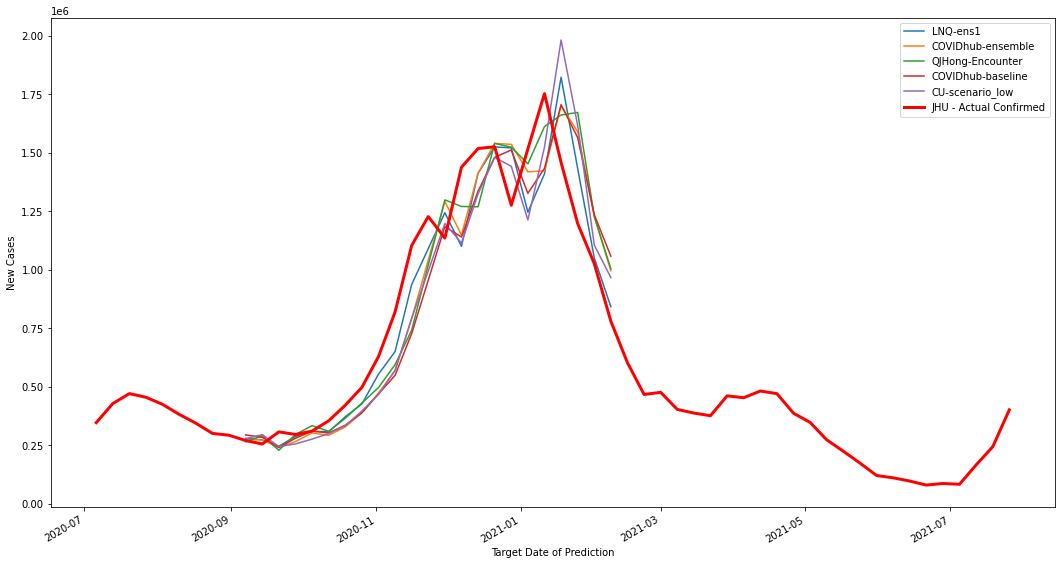

In [13]:
fig, ax = plt.subplots()
for model in stat_df.index[:5]:
    if model == "DDS-NBDS":
        continue
    model_frame = cdc_frames[(cdc_frames["Model"]==model) & (cdc_frames["target"] == "1 wk ahead inc case")][["target_end_date", "point"]]
    model_frame.target_end_date=pd.to_datetime(model_frame.target_end_date)
    model_frame = model_frame.set_index("target_end_date", drop=True)
    model_frame = model_frame[(model_frame.index > start) & (model_frame.index < end)]
    model_frame.sort_index()["point"].plot(figsize=(18,10),ax=ax,  label=model)
    #model_frame.sort_index()["point"].plot(figsize=(18,10),ax=ax, linewidth=1,  label='_nolegend_', color='b')
jhu_weekly_df["WeeklyCases"].plot( linewidth=3,ax=ax,  label="JHU - Actual Confirmed", color='r')
ax.legend()
ax.set(ylabel="New Cases", xlabel = "Target Date of Prediction")
plt.savefig('plots/segment2.png', bbox_inches='tight', dpi=150)

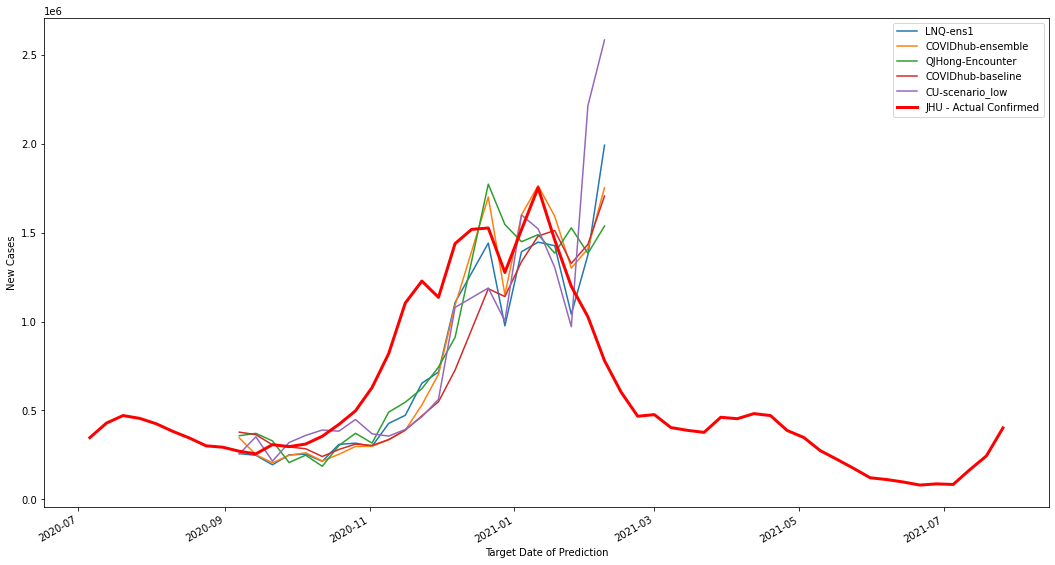

In [33]:
fig, ax = plt.subplots()
for model in stat_df.index[:5]:
    if model == "DDS-NBDS":
        continue
    model_frame = cdc_frames[(cdc_frames["Model"]==model) & (cdc_frames["target"] == "4 wk ahead inc case")][["target_end_date", "point"]]
    model_frame.target_end_date=pd.to_datetime(model_frame.target_end_date)
    model_frame = model_frame.set_index("target_end_date", drop=True)
    model_frame = model_frame[(model_frame.index > start) & (model_frame.index < end)]
    model_frame.sort_index()["point"].plot(figsize=(18,10),ax=ax,  label=model)
    #model_frame.sort_index()["point"].plot(figsize=(18,10),ax=ax, linewidth=1,  label='_nolegend_', color='b')
jhu_weekly_df["WeeklyCases"].plot( linewidth=3,ax=ax,  label="JHU - Actual Confirmed", color='r')
ax.legend()
ax.set(ylabel="New Cases", xlabel = "Target Date of Prediction")
plt.savefig('plots/segment2.png', bbox_inches='tight', dpi=150)

In [34]:
start = "2021-02-15"
end = "2021-07-26"
stats={}
for model in cdc_frames.Model.unique():
    model_frame = cdc_frames[(cdc_frames["Model"]==model) & (cdc_frames["target"] == "4 wk ahead inc case")][["target_end_date", "point"]]
    model_frame = model_frame.set_index("target_end_date", drop=True)
    model_frame = model_frame.sort_index()
    model_target_df = model_frame[(model_frame.index > start) & (model_frame.index < end)]
    target_dates = model_target_df.index.unique()
    jnu_target_df = jhu_weekly_df.loc[list(pd.to_datetime(target_dates) & jhu_weekly_df.index)]
    jnu_target_df.diff = 100*abs(model_target_df.point - jnu_target_df.WeeklyCases)/jnu_target_df.WeeklyCases
    stats[model]={}
    stats[model]["mae"]= round(jnu_target_df.diff.mean(),2)
    stats[model]["pred_count"]= len(jnu_target_df)
    
stat_df =  pd.DataFrame.from_dict(stats,orient='index')
stat_df = stat_df[stat_df.pred_count>= stat_df.pred_count.value_counts().idxmax()]
stat_df = stat_df.sort_values("mae", ascending=True)
stat_df

,mae,pred_count
USC-SI_kJalpha,32.32,22
CU-scenario_low,41.92,22
JHUAPL-Bucky,49.65,22
Covid19Sim-Simulator,50.07,22
COVIDhub-ensemble,52.67,22
CU-nochange,53.66,22
RobertWalraven-ESG,54.10,22
TTU-squider,54.21,22
CU-select,55.86,22
IEM_MED-CovidProject,60.14,22


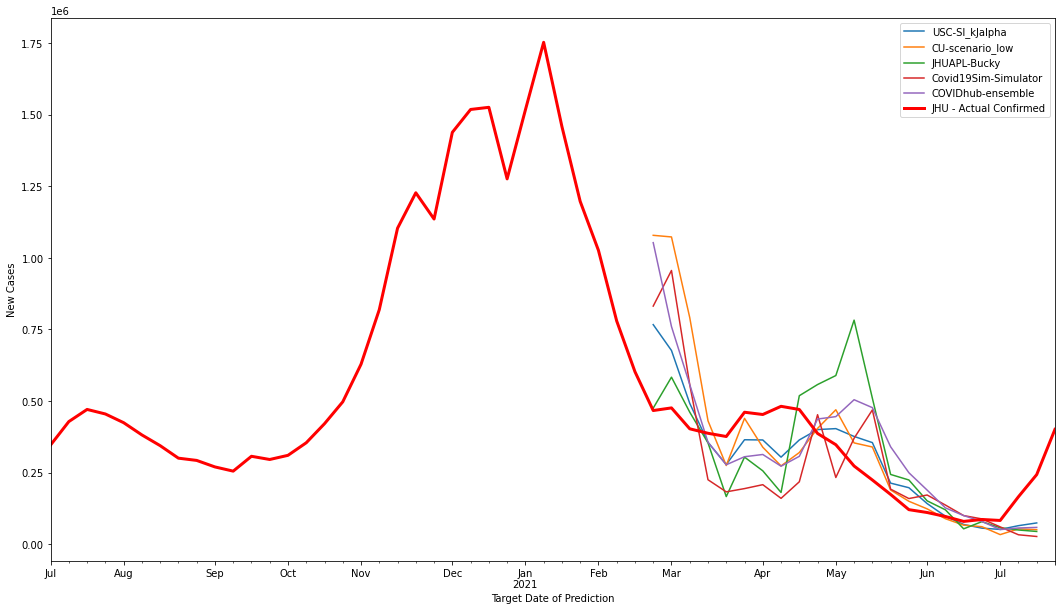

In [35]:
fig, ax = plt.subplots()
for model in stat_df.index[:5]:
    if model == "DDS-NBDS":
        continue
    model_frame = cdc_frames[(cdc_frames["Model"]==model) & (cdc_frames["target"] == "4 wk ahead inc case")][["target_end_date", "point"]]
    model_frame.target_end_date=pd.to_datetime(model_frame.target_end_date)
    model_frame = model_frame.set_index("target_end_date", drop=True)
    model_frame = model_frame[(model_frame.index > start) & (model_frame.index < end)]
    model_frame.sort_index()["point"].plot(figsize=(18,10),ax=ax,  label=model)
    #model_frame.sort_index()["point"].plot(figsize=(18,10),ax=ax, linewidth=1,  label='_nolegend_', color='b')
jhu_weekly_df["WeeklyCases"].plot( linewidth=3,ax=ax,  label="JHU - Actual Confirmed", color='r')
ax.legend()
ax.set(ylabel="New Cases", xlabel = "Target Date of Prediction")
plt.savefig('plots/segment3.png', bbox_inches='tight', dpi=150)